# Programming Assignment 2
## Logistic Regression and Stochastic Methods

Aluno: Francisco Edyvalberty Alenquer Cordeiro \
Matrícula: 518659


# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Utility Functions

## Metrics

In [2]:
def get_mse(y_real, y_pred):
    return np.mean((y_real - y_pred) ** 2)

def get_rmse(y_real, y_pred):
    return np.sqrt(get_mse(y_real, y_pred))

## Standardization

In [3]:
class StandardScaler:
    def __init__(self):
        self.fitted = False

    def fit_transform(self, data):      
        self.mean = data.mean(axis=0)
        self.std = data.std(axis=0)
        self.fitted = True

        scaled_data = (data - self.mean) / self.std
        return scaled_data
    
    def transform(self, data):
        if not self.fitted:
            raise Exception('Scaler not fitted!')

        scaled_data = (data - self.mean) / self.std
        return scaled_data

    def inverse_transform(self, scaled_data):
        if not self.fitted:
            raise Exception('Scaler not fitted!')
        
        original_data = (scaled_data * self.std) + self.mean
        return original_data


## Min-max feature scaling

In [4]:
class MinMaxScaler:
    def __init__(self):
        self.fitted = False

    def fit_transform(self, data):      
        self.maximum = data.max(axis=0)
        self.minimum = data.min(axis=0)
        self.fitted = True

        scaled_data =  (data - self.minimum) / (self.maximum - self.minimum)
        return scaled_data
    
    def transform(self, data):
        if not self.fitted:
            raise Exception('Scaler not fitted!')

        scaled_data =  (data - self.minimum) / (self.maximum - self.minimum)
        return scaled_data

    def inverse_transform(self, scaled_data):
        if not self.fitted:
            raise Exception('Scaler not fitted!')
        
        original_data = (self.maximum - self.minimum) * scaled_data + self.minimum
        return original_data

# Task 1

In [203]:
data = np.genfromtxt('../data/breastcancer.csv', delimiter=',')
print('Shape:', data.shape)
data[:2,:]

Shape: (569, 31)


array([[1.799e+01, 1.038e+01, 1.228e+02, 1.001e+03, 1.184e-01, 2.776e-01,
        3.001e-01, 1.471e-01, 2.419e-01, 7.871e-02, 1.095e+00, 9.053e-01,
        8.589e+00, 1.534e+02, 6.399e-03, 4.904e-02, 5.373e-02, 1.587e-02,
        3.003e-02, 6.193e-03, 2.538e+01, 1.733e+01, 1.846e+02, 2.019e+03,
        1.622e-01, 6.656e-01, 7.119e-01, 2.654e-01, 4.601e-01, 1.189e-01,
        0.000e+00],
       [2.057e+01, 1.777e+01, 1.329e+02, 1.326e+03, 8.474e-02, 7.864e-02,
        8.690e-02, 7.017e-02, 1.812e-01, 5.667e-02, 5.435e-01, 7.339e-01,
        3.398e+00, 7.408e+01, 5.225e-03, 1.308e-02, 1.860e-02, 1.340e-02,
        1.389e-02, 3.532e-03, 2.499e+01, 2.341e+01, 1.588e+02, 1.956e+03,
        1.238e-01, 1.866e-01, 2.416e-01, 1.860e-01, 2.750e-01, 8.902e-02,
        0.000e+00]])

In [229]:
def train_test_split(data, train_size_perc, random_seed=264852):
    N = data.shape[0]
    train_size = int(train_size_perc * N)

    indexes = np.arange(0, N, 1)

    np.random.seed(random_seed)
    train_idx = np.random.choice(indexes, train_size, replace=False)
    test_idx = np.delete(indexes, train_idx)

    train_data = data[train_idx]
    test_data = data[test_idx]

    X_train = train_data[:,:-1]
    y_train = train_data[:,[-1]]

    X_test = test_data[:,:-1]
    y_test = test_data[:,[-1]]

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_test_split(data, 0.8)

print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_train shape: (455, 30)
y_train shape: (455, 1)
X_test shape: (114, 30)
y_test shape: (114, 1)


In [230]:
X_scaler = StandardScaler()
X_train_scaled = X_scaler.fit_transform(X_train)
X_train_scaled

array([[-1.49765184, -0.56867644, -1.47949837, ..., -1.72684485,
        -0.73743158,  0.256437  ],
       [ 0.18395277, -1.22255334,  0.28189505, ..., -0.02826581,
        -0.09974236,  0.44389088],
       [ 1.86386334, -0.45207601,  1.78205271, ...,  1.51087983,
        -0.33011176, -0.7327511 ],
       ...,
       [ 0.16418911,  1.07287467,  0.13220737, ..., -0.66201362,
        -0.60889213, -0.62836716],
       [-0.14920597, -0.09998845, -0.13312943, ...,  0.50062388,
        -0.36850666, -0.38790155],
       [ 0.72321818,  2.00110552,  0.69527912, ...,  0.4469684 ,
        -1.11637256, -0.31466884]])

In [338]:
def sigmoid(x):
    return 1 / (1+np.exp(-x))

def cross_entropy_loss(y, y_pred_proba):
    cost_1 = y.T @ np.log(y_pred_proba)
    cost_0 = (1-y).T @ np.log(1-y_pred_proba)
    j = -(1/len(y)) * (cost_1 + cost_0)
    return j.ravel()[0]

def accuracy(y, y_pred):
    right_prediction = y == y_pred
    accuracy = right_prediction.sum() / len(y)
    return accuracy

def recall(y, y_pred):
    right_prediction = y == y_pred
    right_prediction = right_prediction[y == 1]
    accuracy = right_prediction.sum() / y.sum()
    return accuracy

In [339]:


class MyLogisticRegression():
    def __init__(
        self, 
        alpha, 
        n_iterations
    ):        
        self.alpha = alpha        
        self.n_iterations = n_iterations

    def initialize(self, X, y, random_state=654812):
        rnd_state = np.random.RandomState(random_state)
        self.X = np.hstack(
            [np.ones((X.shape[0], 1)), X]
        )
        self.y = y

        self.w = rnd_state.uniform(
            0, 
            1, 
            self.X.shape[1]
        ).reshape(-1, 1)

    def fit(self, X, y, random_state=654812):
        self.initialize(X, y, random_state)
        self.gradient_descent()

    def gradient_descent(self):
        for i in range(self.n_iterations):
            y_pred_proba = sigmoid(self.X @ self.w)
            e = (self.y - y_pred_proba) 
            self.w = self.w + ((1/len(self.y)) * self.alpha * (e.T @ self.X)).reshape(-1, 1)

            # print(cross_entropy_loss(self.y, sigmoid(self.X @ self.w)))

    def predict_proba(self, X):
        X = np.hstack(
            [np.ones((X.shape[0], 1)), X]
        )
        predict_proba = sigmoid(X @ self.w)
        return predict_proba

    def predict(self, X, threshold=0.5):
        X = np.hstack(
            [np.ones((X.shape[0], 1)), X]
        )
        predict_proba = sigmoid(X @ self.w)
        predict_label = np.where(predict_proba>threshold, 1, 0)
        return predict_label

my_lr = MyLogisticRegression(0.1, 1000)
my_lr.fit(X_train_scaled, y_train)


In [341]:
from sklearn.metrics import classification_report

In [343]:
X_test_scaled = X_scaler.transform(X_test)
my_y_pred = my_lr.predict(X_test_scaled)
my_y_pred_proba = my_lr.predict_proba(X_test_scaled)
print('Acuracy:', accuracy(y_test, my_y_pred))
print('Recall:', recall(y_test, my_y_pred))
print('Log Loss:', cross_entropy_loss(y_test, my_y_pred_proba))

print(classification_report(y_test, my_y_pred))

Acuracy: 0.9736842105263158
Recall: 1.0
Log Loss: 0.08015880158280268
              precision    recall  f1-score   support

         0.0       1.00      0.93      0.97        45
         1.0       0.96      1.00      0.98        69

    accuracy                           0.97       114
   macro avg       0.98      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



(array([38.,  1.,  0.,  1.,  2.,  1.,  2.,  2.,  5., 62.]),
 array([6.47383175e-11, 9.99996260e-02, 1.99999252e-01, 2.99998878e-01,
        3.99998504e-01, 4.99998130e-01, 5.99997756e-01, 6.99997382e-01,
        7.99997008e-01, 8.99996633e-01, 9.99996259e-01]),
 <BarContainer object of 10 artists>)

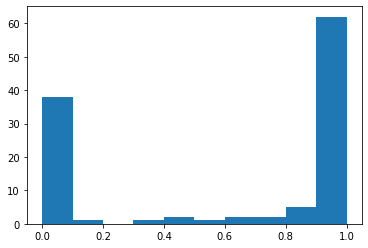

In [334]:
plt.hist(my_y_pred_proba)

In [317]:
my_y_pred.sum()

71

In [344]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


lr = LogisticRegression()

lr.fit(X_train_scaled, y_train)

pred = lr.predict(X_test_scaled)
pred_proba = lr.predict_proba(X_test_scaled)

print('Acuracy:', accuracy_score(y_test, pred))
print('Log Loss:', log_loss(y_test, pred_proba))

print(classification_report(y_test, pred))

Acuracy: 0.9736842105263158
Log Loss: 0.0685480140602806
              precision    recall  f1-score   support

         0.0       1.00      0.93      0.97        45
         1.0       0.96      1.00      0.98        69

    accuracy                           0.97       114
   macro avg       0.98      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



C:\Users\edyalenquer\.conda\envs\ml-project\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(array([39.,  0.,  1.,  2.,  0.,  2.,  2.,  1.,  7., 60.]),
 array([1.82636744e-10, 9.99989581e-02, 1.99997916e-01, 2.99996874e-01,
        3.99995832e-01, 4.99994790e-01, 5.99993748e-01, 6.99992706e-01,
        7.99991664e-01, 8.99990622e-01, 9.99989580e-01]),
 <BarContainer object of 10 artists>)

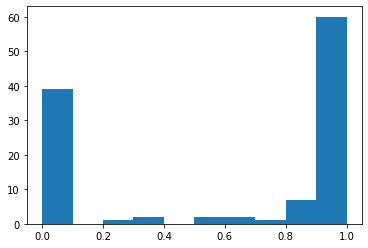

In [330]:
plt.hist(pred_proba[:, 1])